![ToOL-PRO-BES.png](Info/ToOL-PRO-BES.png)

## Import packages

In [16]:
import pandas as pd
from tqdm import trange, tqdm
#from tqdm.notebook import trange, tqdm

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import datetime
from datetime import datetime, timedelta, timezone
from pytz import timezone

import os
import re

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import time
import numpy as np
import math
import seaborn as sns

import requests
import io

## Setup from Info.xlsx

In [17]:
info = pd.read_excel("Info/Info.xlsx", sheet_name=None, index_col=0)
print(*info.keys(), sep = " | ")

setup | datasets | parameters | parameters_ave | charts | charts_ave | plots | colours


## Functions

In [18]:
# Date Functions
def set_date(date_str, old_tz, dt_format = "%d/%m/%Y %H:%M:%S"):
    if date_str == 'NaT':
        return pd.NaT
    else:
        datetime_set_naive = datetime.strptime(date_str, dt_format)
        datetime_set_old = timezone(old_tz).localize(datetime_set_naive)
        datetime_set_utc = datetime_set_old.astimezone(timezone('UTC'))
        return datetime_set_utc

def date_parser(date_, time_, dt_format = "%d/%m/%Y %H:%M:%S"):
    return set_date(date_ + " " + time_, 'UTC', dt_format)

def date_parserYMD(date_, time_, dt_format = "%Y-%m-%d %H:%M:%S"):
    return set_date(date_ + " " + time_, 'UTC', dt_format)


# Experiment start/end date
date_start = set_date(str(info['setup'].loc['date_start_utc','value']), "UTC", "%Y-%m-%d %H:%M:%S")
if pd.isna(info['setup'].loc['date_end_utc','value']):
    date_now = datetime.now(timezone('UTC'))
    info['setup'].loc['date_end_utc','value'] = date_now
else:
    date_now = set_date(str(info['setup'].loc['date_end_utc','value']), "UTC", "%Y-%m-%d %H:%M:%S")

# Date Functions continued
def date_range(window=-1, start=date_start, end=date_now):
    if pd.isna(start):
        start = date_start
    if pd.isna(end):
        end = date_now
    if window != -1:
        if not pd.isna(window):
            start = end - timedelta(days=window)
    return start, end

info['setup']

,value
id,
project,ToOLTuBES v2
date_start_utc,2019-06-04 13:03:17
date_end_utc,2020-02-06 13:00:43.567856+00:00


## Process Information sheets from Info.xlsx

### Datasets:

In [19]:
info['datasets']

,folder,selection,melt,data_folder_path,supp_data_filepath,file_pat,skiprows,Slim,Del_unit_rows,Add_blank_rows
dataset,,,,,,,,,,
UO,1,UO.wide,UO.wide,C:/Users/Martin/Google Drive/ToOLTuBES/LAB/Dat...,C:/Users/Martin/Google Drive/ToOLTuBES/LAB/Dat...,.csv,0,1.0,NaN,1.0
NWL,1,NWL,NWL,C:/Users/Martin/Google Drive/ToOLTuBES/LAB/Dat...,NaN,.xlsx,2,NaN,1.0,NaN
Skid,1,Skid,Skid.ave,C:/Users/Martin/Google Drive/BEWISE_shared/Ski...,NaN,.CSV,2,NaN,NaN,1.0
Skid,2,Skid,Skid.ave,C:/Users/Martin/Google Drive/BEWISE_shared/Ski...,NaN,.CSV,3,NaN,NaN,1.0
SampLog,1,SampLog.wide,SampLog.wide.ave,C:/Users/Martin/Google Drive/BEWISE_shared/Sam...,NaN,.csv,0,1.0,NaN,NaN
Sensor,1,SENSOR,SENSOR,C:/Users/Martin/Google Drive/ToOLTuBESv2/LAB/T...,NaN,\d\d_\d\d_\d\d\d\d\.csv,0,NaN,NaN,NaN
Events,1,EV.wide,EV.ave,C:/Users/Martin/Google Drive/ToOLTuBESv2/LAB/T...,C:/Users/Martin/Google Drive/ToOLTuBESv2/LAB/T...,.csv,0,NaN,NaN,NaN


### Parameters:

In [20]:
info['parameters']

,code,selected,parameter,parameter_ave,parameter_lab,chart,colours,ribbons,points,fills,ltypes,binary_bar,legend_shows
dataset,,,,,,,,,,,,,
Sensor,A1 V,1,BES_A1__V,BES_1__V_ave,!!BES 1A!!,BES_VA_indiv,0.0,0.0,NaN,NaN,solid,NaN,True
Sensor,A2 V,1,BES_A2__V,BES_2__V_ave,!!BES 2A!!,BES_VA_indiv,3.0,3.0,NaN,NaN,solid,NaN,True
Sensor,A3 V,1,BES_A3__V,BES_3__V_ave,!!BES 3A!!,BES_VA_indiv,5.0,5.0,NaN,NaN,solid,NaN,True
Sensor,A4 V,1,BES_A4__V,BES_4__V_ave,!!BES 4A!!,BES_VA_indiv,6.0,6.0,NaN,NaN,solid,NaN,True
Sensor,B1 V,1,BES_B1__V,BES_1__V_ave,!!BES 1B!!,BES_VB_indiv,0.0,0.0,NaN,NaN,longdash,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Events,HOSE_B_STATUS,0,HOSE_B_STATUS,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
Events,HOSE_C_STATUS,0,HOSE_C_STATUS,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
Events,TILT_SP,0,TILT_SP,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [21]:
info['parameters_ave']

,selected,parameter_ave,parameter_lab,chart,colours,ribbons,fills,points,ltypes,binary_bar,legend_shows
dataset,,,,,,,,,,,
Sensor_ave,1,BES_1__V_ave,!!BES 1!!,BES_V_ave,1.0,1.0,NaN,NaN,solid,NaN,True
Sensor_ave,1,BES_2__V_ave,!!BES 2!!,BES_V_ave,4.0,4.0,NaN,NaN,solid,NaN,True
Sensor_ave,1,BES_3__V_ave,!!BES 3!!,BES_V_ave,7.0,7.0,NaN,NaN,solid,NaN,True
Sensor_ave,1,BES_4__V_ave,!!BES 4!!,BES_V_ave,10.0,10.0,NaN,NaN,solid,NaN,True
Sensor_ave,1,BES_1__C_ave,!!BES 1!!,BES_C_ave,1.0,1.0,NaN,NaN,solid,NaN,True
Sensor_ave,1,BES_2__C_ave,!!BES 2!!,BES_C_ave,4.0,4.0,NaN,NaN,solid,NaN,True
Sensor_ave,1,BES_3__C_ave,!!BES 3!!,BES_C_ave,7.0,7.0,NaN,NaN,solid,NaN,True
Sensor_ave,1,BES_4__C_ave,!!BES 4!!,BES_C_ave,10.0,10.0,NaN,NaN,solid,NaN,True
Sensor_ave,1,BES_SUM__V_ave,∑[BESs]₅,BES_V_ave,14.0,14.0,NaN,NaN,solid,NaN,True


### Charts:

In [22]:
info['charts']

,chart,selected,chart_lab,ylab,ymin,ymax,height
row_order,,,,,,,
1,BES.INDIV_CA,1,BES,"atop(textstyle(!!Current Density!!),textstyle(...",0,40,10
2,BES.INDIV_CB,1,BES,"atop(textstyle(!!Current Density!!),textstyle(...",0,40,10
3,BES.INDIV_CC,1,BES,"atop(textstyle(!!Current Density!!),textstyle(...",0,40,10
4,REXT.INDIV,1,REXT,"atop(R[textstyle(!!Ext!!)],textstyle(!!(!!*Ome...",0,400,8
5,OCP.INDIV,1,OCP,textstyle(!!OCP!!),0,1,6
6,BOD,1,BOD,"atop(textstyle(!!BOD!![5]),textstyle(!!(mg/l O...",0,300,10
7,COD,1,COD,"atop(textstyle(!!COD!!),textstyle(!!(mg/l O!![...",0,600,10
8,TEMP.INDIV,1,Temperature,"atop(textstyle(!!Temperature!!),textstyle(!!(°...",0,60,10
9,TEMP_PROCESS.INDIV,1,TEMP_PROCESS,"atop(textstyle(!!Control!!),textstyle(!!Temp (...",0,150,8


In [23]:
info['charts_ave']

,chart,selected,chart_lab,ylab,ymin,ymax,height
order,,,,,,,
1,BES.INDIV_CA,1,BES,Current Density\n(μA/cm²),0,40,10
2,BES.INDIV_CB,1,BES,Current Density\n(μA/cm²),0,40,10
3,BES.INDIV_CC,1,BES,Current Density\n(μA/cm²),0,40,10
4,REXT.INDIV,1,REXT,"R[textstyle(!!Ext!!)],textstyle(!!(!!*Omega*!!...",0,400,8
5,OCP.INDIV,1,OCP,textstyle(!!OCP!!),0,1,6
6,BOD,1,BOD,"atop(textstyle(!!BOD!![5]),textstyle(!!(mg/l O...",0,300,10
7,COD,1,COD,"atop(textstyle(!!COD!!),textstyle(!!(mg/l O!![...",0,600,10
8,TEMP.INDIV,1,Temperature,"atop(textstyle(!!Temperature!!),textstyle(!!(°...",0,60,10
9,TEMP_PROCESS.INDIV,1,TEMP_PROCESS,"atop(textstyle(!!Control!!),textstyle(!!Temp (...",0,150,8


### Plots:

In [24]:
plots = []
for plot, row in info['plots'].iterrows():
    plot_range = date_range(window = row['plot_range_window'], start = set_date(str(row['plot_range_start']), "UTC", "%Y-%m-%d %H:%M:%S"), end = set_date(str(row['plot_range_end']), "UTC", "%Y-%m-%d %H:%M:%S"))
    info['plots'].loc[plot, 'plot_range_start'] = plot_range[0]
    info['plots'].loc[plot, 'plot_range_end'] = plot_range[1]
    info['plots'].loc[plot, 'plot_range_window'] = plot_range[1] - plot_range[0]
    plots.append(plot)

del plot, plot_range, row

info['plots']

,plot_status,plot_res,plot_range_window,plot_range_start,plot_range_end,plot_label
plot,,,,,,
high,ON,0,"7 days, 0:00:00",2020-01-30 13:00:43.567856+00:00,2020-02-06 13:00:43.567856+00:00,High Resolution
med,ON,5,"31 days, 0:00:00",2020-01-06 13:00:43.567856+00:00,2020-02-06 13:00:43.567856+00:00,Medium Resolution
low,ON,120,"246 days, 23:57:26.567856",2019-06-04 13:03:17+00:00,2020-02-06 13:00:43.567856+00:00,Low Resolution
custom1,OFF,0,"1 day, 0:00:00",2019-06-04 13:03:17+00:00,2019-06-05 13:03:17+00:00,Custom Plot


### Colours:

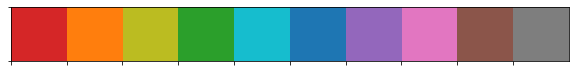

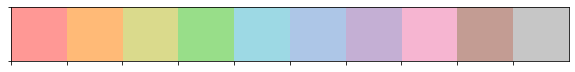

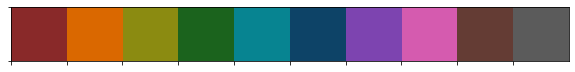

In [25]:
info['colours']

info['colours']['rgb'] = list(zip((info['colours']['r']/255), (info['colours']['g']/255), (info['colours']['b']/255)))
colour_palettes = {}
colour_palettes['all'] = info['colours']['rgb'].tolist()

for theme in info['colours']['theme'].unique():
    colour_palettes[theme] = info['colours'].query('theme == "' + theme + '"')['rgb'].tolist()
    sns.palplot(colour_palettes[theme])

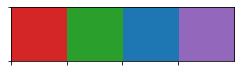

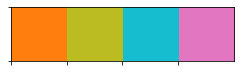

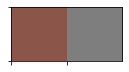

In [26]:
sns.palplot([colour_palettes['mid'][i] for i in [0,3,5,6]])
sns.palplot([colour_palettes['mid'][i] for i in [1,2,4,7]])
sns.palplot([colour_palettes['mid'][i] for i in [8,9]])

## Import Data
### Custom Support Data Functions

In [27]:
def get_UO_support_data(dataset_f_info, dataset = "UO"):
    
    def import_UO_log_dates():
        UO_log_dates = pd.read_csv(dataset_f_info['supp_data_filepath'][dataset], sep = "\t")
        UO_log_dates['start'] = pd.to_datetime(UO_log_dates['start'], format="%Y-%m-%d")
        UO_log_dates['end'] = pd.to_datetime(UO_log_dates['end'], format="%Y-%m-%d")
        return UO_log_dates
    
    UO_log_dates = import_UO_log_dates()
    
    #Check LogDates file
    if max(UO_log_dates['end']) < date_now.date() - timedelta(days=1):
        print("Retrieving latest Urban Observatory data...")
        # api-endpoint 
        URL = "http://uoweb3.ncl.ac.uk/api/v1.1/sensors/data/csv/?"
        # location given here 
        poly = '0103000000010000000600000001000020a2baf9bf58094ee3a2764b4001000020f268fbbf90c059b5b5714b4000000020ba37fbbfc4e78445c6704b4001000020b203fbbf9ce8d60e68714b40010000209a59f9bf346a0efd06714b4001000020a2baf9bf58094ee3a2764b40'
        # defining a params dict for the parameters to be sent to the API 
        PARAMS = {'polygon_wkb': poly,
                  'starttime': max(UO_log_dates['end']).strftime("%Y%m%d%H%M%S"), #"%Y%m%d%H%M%S"
                  'endtime': date_now.strftime("%Y%m%d%H%M%S"), #"%Y%m%d%H%M%S"
                  'data_variable': 'River Level,Temperature,Rainfall'} 
        # sending get request and saving the response as response object 
        data_content = requests.get(url = URL, params = PARAMS).content
        UO_data = pd.read_csv(io.StringIO(data_content.decode("utf-8")))
        min_date = pd.to_datetime(min(UO_data['Timestamp'])).strftime("%Y-%m-%d")
        max_date = pd.to_datetime(max(UO_data['Timestamp'])).strftime("%Y-%m-%d")
        
        if pd.to_datetime(max_date) > max(UO_log_dates['end']):
            UO_data.to_csv(dataset_f_info['data_folder_path'][dataset] + "UO_data_" + str(min_date) + "_to_" + str(max_date) + ".csv",
                           index = False)
            UO_Files = []
            for filename in tqdm(os.listdir(str(dataset_f_info['data_folder_path'][dataset])), desc = "Open existing UO files"):
                if re.search(dataset_f_info['file_pat'][dataset], filename) and not filename.startswith('.'):
                    UO_Files.append(filename)
            UO_starts = []
            for string in UO_Files: UO_starts.append(string[8:18])
            UO_ends = []
            for string in UO_Files: UO_ends.append(string[22:32])


            new_UO_file_data = {'file': UO_Files,
                                'start': UO_starts,
                                'end': UO_ends}
            UO_log_dates_new = pd.DataFrame(new_UO_file_data, columns = ['file', 'start', 'end'])
            UO_log_dates_new.to_csv(dataset_f_info['supp_data_filepath'][dataset], index = False, sep = "\t")
            print("Urban Observatory data updated!")
        else:
            print("Urban Observatory data up-to-date!")
        
    UO_log_dates = import_UO_log_dates
    
    return UO_log_dates

def get_Events_support_data(dataset_f_info, dataset = "Events"):
    Events_info = pd.read_csv(dataset_f_info['supp_data_filepath'][dataset], sep = "\t", index_col = "Code")
    return Events_info

custom_preimport_functions = {'UO': get_UO_support_data,
                              'Events': get_Events_support_data}

### Custom Imported Data Functions

### Data Import Functions

In [28]:
#Data import
def import_data(dataset):
    dataset_all_days = []
    for folder in range(1,len(info['datasets'].query('dataset == "' + dataset + '"'))+1):
        print(dataset + ": Folder " + str(folder))
        
        #Shorthand info:
        dataset_f_info = info['datasets'].query('dataset == "' + dataset + '" & folder == "' + str(folder) + '"')
        #File format to import
        f_file_import = select_file_importer(dataset, dataset_f_info)
        
        #Custom pre-import functions
        if dataset in custom_preimport_functions:
            dataset_supp_data = custom_preimport_functions[dataset](dataset_f_info)
        else:
            dataset_supp_data = ""
        #Import files
        for filename in tqdm(os.listdir(str(dataset_f_info['data_folder_path'][dataset])), desc = "Open files to import"):
            if re.search(dataset_f_info['file_pat'][dataset], filename) and not filename.startswith('.'):
                day_df = file_import_handler(dataset, dataset_f_info, filename, dataset_supp_data, f_file_import)
                # Keep if longer than 0 lines
                if len(day_df) > 0:
                    #Keep if within DateTime range in Info file
                    if max(day_df['DateTime']) >= min(info['plots']['plot_range_start']) and \
                       min(day_df['DateTime']) <= max(info['plots']['plot_range_end']):
                        dataset_all_days.append(day_df)
    
    #Create one dataframe from all days data
    dataset_all_data = pd.concat(dataset_all_days, axis=0, ignore_index=True)
    dataset_all_data.sort_values(by=['DateTime'], inplace=True)
    dataset_all_data = dataset_all_data.reset_index(drop=True)
    
    dataset_all_data = dataset_all_data[dataset_all_data['DateTime'] >= min(info['plots']['plot_range_start'])]
    dataset_all_data = dataset_all_data[dataset_all_data['DateTime'] <= max(info['plots']['plot_range_end'])]
    
    return(dataset_all_data)

#File Import functions
def select_file_importer(dataset, dataset_f_info):
    if re.search("xls", dataset_f_info['file_pat'][dataset], re.IGNORECASE):
        return file_import_functions["xls"]
    elif re.search("csv", dataset_f_info['file_pat'][dataset], re.IGNORECASE):
        return file_import_functions["csv"]
    elif re.search("txt", dataset_f_info['file_pat'][dataset], re.IGNORECASE):
        return file_import_functions["txt"]
    else:
        raise ValueError("Unknown file pattern!")

def file_import_xls(dataset, dataset_f_info, filename):
    df = pd.read_excel("".join([str(dataset_f_info['data_folder_path'][dataset]), filename]), 
                       skiprows = dataset_f_info['skiprows'][dataset])
    return df

def file_import_csv(dataset, dataset_f_info, filename):
    df = pd.read_csv("".join([str(dataset_f_info['data_folder_path'][dataset]), filename]), 
                     skiprows = dataset_f_info['skiprows'][dataset])
    return df

def file_import_txt(dataset, dataset_f_info, filename):
    df = pd.read_csv("".join([str(dataset_f_info['data_folder_path'][dataset]), filename]), 
                     sep="\t", skiprows = dataset_f_info['skiprows'][dataset])
    return df

file_import_functions = {'xls': file_import_xls,
                         'csv': file_import_csv,
                         'txt': file_import_txt}

def file_import_handler(dataset, dataset_f_info, filename, dataset_supp_data, f_file_import):
    day_df = f_file_import(dataset, dataset_f_info, filename)
    if len(day_df) > 0:
        # Name parameter columns
        day_df = day_df.rename(columns=dict(zip(info['parameters'].query('dataset == "' + dataset + '"')['code'], 
                                                info['parameters'].query('dataset == "' + dataset + '"')['parameter'])))
        # Delete unit rows
        if not pd.isna(dataset_f_info['Del_unit_rows'][dataset]):
            day_df = day_df.drop(0).reset_index()
        ##Load custom data mod function?
        if dataset in custom_import_functions:
            day_df = custom_import_functions[dataset](day_df, filename, dataset_supp_data, dataset_f_info, dataset)
        
        #Choose selected parameters
        selected_pars = list(info['parameters'].query('dataset == "' + dataset + '" & selected == 1')['parameter'].values)
        day_df = day_df[['DateTime'] + selected_pars]
        #Add blank row between files - to be implemented
        #if len(day_df) > 0:
        #    if not pd.isna(dataset_f_info['Add_blank_rows'][dataset]):
        #        day_df = day_df.append(pd.Series(), ignore_index=True)
                

    return(day_df)

In [29]:
def mod_imported_Sensor_data(day_df, filename, dataset_supp_data, dataset_f_info, dataset = "Sensor"):
    day_df['DateTime'] = day_df['Date'] + " " + day_df['Time']
    day_df['DateTime'] = pd.to_datetime(day_df['DateTime'], format = '%d/%m/%Y %H:%M:%S')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_localize('UTC')
    
    #Make on/off events integer binary numbers 1/0
    #on_events = ["^ON$", "^RUNNING$", "^CW$", "^AUTO$"]
    #off_events = ["^OFF$", "^STOP$", "^CCW$", "^MANUAL$"]

    #all_rgx = re.compile("|".join(on_events + off_events))
    #on_rgx = re.compile("|".join(on_events))
    #off_rgx = re.compile("|".join(off_events))
    
    #Sensor_events = {'ON': 1,
    #                 'RUNNING': 1,
    #                 'CW': 1,
    #                 'AUTO': 1,
    #                 'OFF': 0,
    #                 'STOP': 0,
    #                 'CCW': 0,
    #                 'MANUAL': 0}

    #string_cols = (day_df.applymap(type) == str).all(0).values
    #for col in day_df.iloc[:, string_cols]:
    #    if day_df[col].str.contains(all_rgx).any():
    #        day_df[col] = day_df[col].replace(on_rgx, '1', regex=True)
    #        day_df[col] = day_df[col].replace(off_rgx, '0', regex=True)
    #        day_df[col] = day_df[col].astype(int)
    #for col in day_df.iloc[:, string_cols]:
    #if day_df.iloc[:, string_cols].str.contains(all_rgx).any():
    #day_df[[i for i in list(day_df.columns) if i not in ['DateTime', 'Date', 'Time']]] = \
    #day_df[[i for i in list(day_df.columns) if i not in ['DateTime', 'Date', 'Time']]].replace(Sensor_events).apply(pd.to_numeric)
    #day_df.iloc[:, string_cols] = day_df.astype(int)
    
    #Current density
    day_df.iloc[:, day_df.columns.str.contains("__C")] = day_df.iloc[:, day_df.columns.str.contains("__C")]/(math.pi*(0.6)**2*10)
    #Sum Current density
    day_df.iloc[:, day_df.columns.str.contains("SUM__C")] = day_df.iloc[:, day_df.columns.str.contains("SUM__C")]/4
    
    #Sensible tilt (up = positive)
    day_df['SENSOR_TILT'] = -day_df['SENSOR_TILT']

    return(day_df)

def mod_imported_Skid_data(day_df, filename, dataset_supp_data, dataset_f_info, dataset = "Skid"):
    day_df = day_df.rename(columns={"TIME": "DateTime"})
    day_df['DateTime'] = pd.to_datetime(day_df['DateTime'], format = '%Y/%m/%d %H:%M:%S.%f')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_localize('UTC')
    selected_pars = list(info['parameters'].query('dataset == "' + dataset + '" & selected == 1')['parameter'].values)
    day_df = day_df[day_df[selected_pars].sum(axis = 1, skipna = True) != 0]
    return(day_df)

def mod_imported_SampLog_data(day_df, filename, dataset_supp_data, dataset_f_info, dataset = "SampLog"):
    day_df = day_df.rename(columns={"Date": "DateTime"})
    day_df['DateTime'] = pd.to_datetime(day_df['DateTime'], format = '%d/%m/%Y %H:%M')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_localize('Europe/London')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_convert('UTC')

    selected_read_cols = ['R1', 'R2', 'R3']
    day_df[selected_read_cols] = day_df[selected_read_cols].apply(pd.to_numeric, errors='coerce')

    #Average readings
    day_df['Read_ave'] = day_df[selected_read_cols].mean(axis = 1, skipna = True)
    
    #Widen DF
    day_df_wide = pd.pivot_table(day_df,values='Read_ave',index=['DateTime', 'Location'],columns=['Type','Vial'])
    #Fix col header and names
    day_df_wide.columns = map(''.join, (str(v) for v in day_df_wide.columns))
    day_df_wide.columns = [re.sub(r'\W', '', i) for i in day_df_wide.columns]
    day_df_wide.columns = [s[:len(s)-1] + "_" + s[len(s)-1:] for s in day_df_wide.columns]
    day_df_wide = day_df_wide.reset_index()
    
    return(day_df_wide)

def mod_imported_NWL_data(day_df, filename, dataset_supp_data, dataset_f_info, dataset = "NWL"):
    day_df['DateTime'] = day_df['DATE'].astype(str) + " " + day_df['TIME']
    day_df['DateTime'] = pd.to_datetime(day_df['DateTime'], format = '%Y-%m-%d %H:%M')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_localize('Europe/London')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_convert('UTC')
    
    day_df = day_df[day_df['SITE'].str.contains('SETTLED')]
    
    return(day_df)

def mod_imported_UO_data(day_df, filename, dataset_supp_data, dataset_f_info, dataset = "UO"):
    day_df['DateTime'] = pd.to_datetime(day_df['Timestamp'], format = '%Y-%m-%d %H:%M:%S')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_localize('UTC')
  
    # Create Type column
    day_df['Type'] = day_df['Sensor Name'].astype(str) + "_" + day_df['Variable']
  
    #Widen DF
    day_df_wide = pd.pivot_table(day_df,values='Value',index=['DateTime'],columns=['Type'])
    #Fix col header and names
    day_df_wide = day_df_wide.reset_index()
    day_df_wide = day_df_wide.rename(columns=dict(zip(info['parameters'].query('dataset == "' + dataset + '"')['code'], 
                                                info['parameters'].query('dataset == "' + dataset + '"')['parameter'])))
    return(day_df_wide)

custom_import_functions = {'Sensor': mod_imported_Sensor_data,
                           'Skid': mod_imported_Skid_data,
                           'SampLog': mod_imported_SampLog_data,
                           'NWL': mod_imported_NWL_data,
                           'UO': mod_imported_UO_data}

### Data Import

In [30]:
selected_datasets = list(info['parameters'].query('selected == 1').index.unique())
selected_datasets

['Sensor', 'Skid', 'SampLog', 'NWL', 'UO']

In [31]:
dataset_data = []
for dataset in tqdm(selected_datasets, desc = "Import data from each dataset"):
    dataset_data.append(import_data(dataset))

.74it/s]
Open files to import: 100%|██████████| 173/173 [00:13<00:00, 12.86it/s]

Open files to import:   0%|          | 0/309 [00:00<?, ?it/s]Skid: Folder 2

Import data from each dataset:  60%|██████    | 3/5 [01:47<01:18, 39.18s/it]
SampLog: Folder 1
NWL: Folder 1
Import data from each dataset:  80%|████████  | 4/5 [01:48<00:27, 27.66s/it]UO: Folder 1
Retrieving latest Urban Observatory data...

Open files to import:   0%|          | 0/4 [00:00<?, ?it/s]Urban Observatory data up-to-date!

Import data from each dataset: 100%|██████████| 5/5 [01:54<00:00, 22.90s/it]


In [32]:
dataset_data

[                        DateTime  BES_A1__V  BES_A2__V  BES_A3__V  BES_A4__V  \
 777    2019-06-04 13:03:45+00:00       44.0      219.2      213.0      221.8   
 778    2019-06-04 13:04:45+00:00       95.1      231.7      244.1      221.9   
 779    2019-06-04 13:05:45+00:00       64.9      217.5      225.8      222.2   
 780    2019-06-04 13:06:45+00:00       58.9      217.3      217.9      220.2   
 781    2019-06-04 13:07:45+00:00       58.9      208.6      217.5      221.2   
 ...                          ...        ...        ...        ...        ...   
 347301 2020-02-06 12:40:20+00:00       15.3       18.0       13.3       14.9   
 347302 2020-02-06 12:41:20+00:00       15.5       18.2       13.7       14.9   
 347303 2020-02-06 12:42:20+00:00       15.3       18.3       13.4       15.1   
 347304 2020-02-06 12:43:20+00:00       15.4       18.0       13.8       14.9   
 347305 2020-02-06 12:44:20+00:00       15.3       18.1       13.5       15.1   
 
         BES_B1__V  BES_B2

In [ ]:
ave_df = pd.DataFrame()

for date in tqdm(day_df_wide['DateTime'].unique(), desc = "Average data"):
    for loc in day_df_wide[(day_df_wide['DateTime'] == date)]['Location'].unique():
        selected_row = day_df_wide[(day_df_wide['DateTime'] == date) & (day_df_wide['Location'] == loc)]
        for par in day_dfx['Type'].unique():
            vals = selected_row[[s for s in day_df_wide.columns if par in s]].values.tolist()[0]
            if list(pd.isna(vals)).count(False) > 0:
                ave = np.nanmean(vals)
                if list(pd.isna(vals)).count(False) > 2:
                    err = np.nanstd(vals)
                else:
                    err = (max(vals) - min(vals))/2
                ave_row = pd.DataFrame({"DateTime": selected_row['DateTime'], "Location": loc, "Type": par, "Read_ave": ave, "Read_err": err})
                ave_df = ave_df.append(ave_row)
ave_df

In [33]:
all_data = pd.concat(dataset_data, axis=0, ignore_index=True, sort=False)
all_data.sort_values(by=['DateTime'], inplace=True)
cols = ['DateTime']  + [col for col in all_data if col != 'DateTime']
all_data = all_data[cols]
all_data = all_data.reset_index(drop=True)

In [34]:
all_data

,DateTime,BES_A1__V,BES_A2__V,BES_A3__V,BES_A4__V,BES_B1__V,BES_B2__V,BES_B3__V,BES_B4__V,BES_C1__V,...,tCOD_2,sCOD_1,sCOD_2,NWL_BOD5,NWL_tCOD,NWL_pH,WU_Temp,EA_Uplevel,EA_Downlevel,WU_Rainfall
0,2019-06-04 13:03:45+00:00,44.0,219.2,213.0,221.8,288.2,289.0,328.2,329.1,245.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-06-04 13:04:45+00:00,95.1,231.7,244.1,221.9,288.6,282.9,325.6,327.3,274.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-06-04 13:05:45+00:00,64.9,217.5,225.8,222.2,288.4,289.3,329.5,329.5,248.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-06-04 13:06:45+00:00,58.9,217.3,217.9,220.2,293.2,290.5,330.3,329.6,248.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-06-04 13:07:45+00:00,58.9,208.6,217.5,221.2,297.8,291.0,330.4,329.7,248.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389934,2020-02-06 12:40:20+00:00,15.3,18.0,13.3,14.9,19.9,13.1,15.8,8.1,20.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389935,2020-02-06 12:41:20+00:00,15.5,18.2,13.7,14.9,20.1,13.2,15.9,8.5,20.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389936,2020-02-06 12:42:20+00:00,15.3,18.3,13.4,15.1,20.1,13.1,16.0,8.2,20.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389937,2020-02-06 12:43:20+00:00,15.4,18.0,13.8,14.9,20.3,13.0,15.9,8.4,20.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
plot_dfs = []

for plot in tqdm(plots, desc = "Assign data to Plot DFs"):
    if info['plots'].loc[plot, 'plot_status'] == 'ON':
        mask = (all_data['DateTime'] >= info['plots'].loc[plot, 'plot_range_start']) & (all_data['DateTime'] <= info['plots'].loc[plot, 'plot_range_end'])
        df = all_data.loc[mask]
        if info['plots'].loc[plot, 'plot_res'] != 0:
            df = df.resample("".join([str(info['plots'].loc[plot, 'plot_res']), 'T']), on='DateTime').mean()
            df = df.reset_index()
        else:
            df = df.reset_index(drop=True)
        plot_dfs.append(df)
    else:
        plot_dfs.append("")

plot_dfs_mlt = []

a = 0
for plot in tqdm(plots, desc = "Melt DFs"):
    if info['plots'].loc[plot, 'plot_status'] == 'ON':
        df = plot_dfs[a].melt(id_vars=['DateTime'], var_name='Parameter', value_name='Value')
        plot_dfs_mlt.append(df)
    else:
        plot_dfs_mlt.append("")
    a = a + 1

Melt DFs: 100%|██████████| 4/4 [00:14<00:00,  3.51s/it]


In [36]:
plot_dfs_mlt

[                        DateTime    Parameter Value
 0      2020-01-30 13:01:18+00:00    BES_A1__V  19.3
 1      2020-01-30 13:02:18+00:00    BES_A1__V  19.3
 2      2020-01-30 13:03:18+00:00    BES_A1__V  19.3
 3      2020-01-30 13:04:18+00:00    BES_A1__V  19.3
 4      2020-01-30 13:05:18+00:00    BES_A1__V  19.7
 ...                          ...          ...   ...
 705593 2020-02-06 12:40:20+00:00  WU_Rainfall   NaN
 705594 2020-02-06 12:41:20+00:00  WU_Rainfall   NaN
 705595 2020-02-06 12:42:20+00:00  WU_Rainfall   NaN
 705596 2020-02-06 12:43:20+00:00  WU_Rainfall   NaN
 705597 2020-02-06 12:44:20+00:00  WU_Rainfall   NaN
 
 [705598 rows x 3 columns],
                         DateTime    Parameter   Value
 0      2020-01-06 13:00:00+00:00    BES_A1__V  20.150
 1      2020-01-06 13:05:00+00:00    BES_A1__V  19.920
 2      2020-01-06 13:10:00+00:00    BES_A1__V  20.160
 3      2020-01-06 13:15:00+00:00    BES_A1__V  19.925
 4      2020-01-06 13:20:00+00:00    BES_A1__V  20.020
 ...

In [ ]:
# Assign chart etc
colors = ["red", "yellow", "orange", "green", "blue", "violet"]

row_order = [1, 1, 1, 1,
        2, 2, 2, 2,
        3, 3, 3, 3,
        4, 4, 4, 4,
        4, 4, 4,
        5,
        6, 6, 6,
        6, 6, 6]
labels = ["1", "2", "3", "4",
          "1", "2", "3", "4",
          "1", "2", "3", "4",
          "SP", "A", "B", "C",
          "BOX", "WATER", "AMBIENT", 
          "PUMP",
          "HA", "HB", "HC",
          "M1", "M2", "M3"]
legend_shows = [True, True, True, True,
                False, False, False, False,
                False, False, False, False,
                True, True, True, True,
                True, True, True,
                True,
                True, True, True,
                True, True, True]

if not os.path.exists("Images"):
    os.mkdir("Images")


In [37]:
colours = []
charts = []
par_labels = []
par_legend_shows = []
for par in plot_dfs_mlt[0].Parameter.unique():
    if par in list(info['parameters']['parameter']):
        temp_info = info['parameters'].query('parameter == "' + par + '"')
    elif par in list(info['parameters_ave']['parameter_ave']):
        temp_info = info['parameters_ave'].query('parameter_ave == "' + par + '"')
    else:
        temp_info = []
    colours.append(temp_info['colours'][0])
    charts.append(temp_info['chart'][0])
    par_labels.append(temp_info['parameter_lab'][0])
    par_legend_shows.append(temp_info['legend_shows'][0])
par_labels

['!!BES 1A!!',
 '!!BES 2A!!',
 '!!BES 3A!!',
 '!!BES 4A!!',
 '!!BES 1B!!',
 '!!BES 2B!!',
 '!!BES 3B!!',
 '!!BES 4B!!',
 '!!BES 1C!!',
 '!!BES 2C!!',
 '!!BES 3C!!',
 '!!BES 4C!!',
 '!!BES 1A!!',
 '!!BES 2A!!',
 '!!BES 3A!!',
 '!!BES 4A!!',
 '!!BES 1B!!',
 '!!BES 2B!!',
 '!!BES 3B!!',
 '!!BES 4B!!',
 '!!BES 1C!!',
 '!!BES 2C!!',
 '!!BES 3C!!',
 '!!BES 4C!!',
 '!!  !!*Sigma*!![BES A]!!',
 '!!  !!*Sigma*!![BES B]!!',
 '!!  !!*Sigma*!![BES C]!!',
 '!!  !!*Sigma*!![BES A]!!',
 '!!  !!*Sigma*!![BES B]!!',
 '!!  !!*Sigma*!![BES C]!!',
 '!!Flow Rate!!',
 '!!Feed Water Temp!!',
 '!!Heated Line A Temp!!',
 '!!Heated Line B Temp!!',
 '!!Heated Line C Temp!!',
 '!!Enclosure Temp!!',
 '!!Ambient Air Temp!!',
 '!!Heated Hose A Temp!!',
 '!!Heated Hose B Temp!!',
 '!!Heated Hose C Temp!!',
 '!!Heated Mat A Temp!!',
 '!!Heated Mat B Temp!!',
 '!!Heated Mat C Temp!!',
 '!!OS Pressure!!',
 '!!Line A Pressure!!',
 '!!Line B Pressure!!',
 '!!Line C Pressure!!',
 '!!Feed pH!!',
 '!!Feed Conductivity!!',
 '

In [38]:
figs = []
a = 0

for plot in tqdm(plots, desc = "Make each plot"):
    if info['plots'].loc[plot, 'plot_status'] == 'ON':
        fig = make_subplots(
            rows=max(rows[0:len(plot_dfs_mlt[a].Parameter.unique())]), cols=1, shared_xaxes=True, vertical_spacing=0.05
        )

        for i in range(0, len(plot_dfs_mlt[a].Parameter.unique())):
            print(plot_dfs_mlt[a].Parameter.unique()[i])
            x_data = plot_dfs_mlt[a][plot_dfs_mlt[a].Parameter == plot_dfs_mlt[a].Parameter.unique()[i]].DateTime
            y_data = plot_dfs_mlt[a][plot_dfs_mlt[a].Parameter == plot_dfs_mlt[a].Parameter.unique()[i]].Value
            name = labels[i]

            fig.add_trace(go.Scatter(x=x_data, y=y_data, mode='lines',
                                     name=name, 
                                     line=dict(color=colours[i], width=1),
                                     connectgaps=True, legendgroup=labels[i], showlegend=legend_shows[i]
                                     ), row=row_order[i], 
                                     col=1
                            )

        # Update yaxis properties
        #fig.update_yaxes(title_text="BES A (uA)", range=[0, max(plot_dfs_mlt[a]['Value'])], row=1, col=1)
        #fig.update_yaxes(title_text="BES B (uA)", range=[0, max(plot_dfs_mlt[a]['Value'])], row=2, col=1)
        #fig.update_yaxes(title_text="BES C (uA)", range=[0, max(plot_dfs_mlt[a]['Value'])], row=3, col=1)
        #fig.update_yaxes(title_text="Temp (°C)",  range=[0, 30], row=4, col=1)
        #fig.update_yaxes(title_text="Pump FR (ml/min)", range=[0, 33], row=5, col=1)
        #fig.update_yaxes(title_text="Heater Temp (°C)", row=6, col=1)

        fig.update_layout(
            paper_bgcolor='rgb(255,255,255,0)',
            legend_bgcolor='rgb(255,255,255,0)',
            font=dict(
                family="Arial", size=11, color="#000000"))
        figs.append(fig)
    else:
        figs.append("")
    a = a + 1

Make each plot:   0%|          | 0/4 [00:00<?, ?it/s]


NameError: name 'rows' is not defined

In [ ]:
a = 0
for plot in tqdm(plots, desc = "Export PDFs"):
    if info['plots'].loc[plot, 'plot_status'] == 'ON':
        figs[a].write_image("Images/fig_" + plot + ".pdf", width=794, height=1123, scale=10 / 3)
    a = a + 1

a = 0
for plot in tqdm(plots, desc = "Export PNGs"):
    if info['plots'].loc[plot, 'plot_status'] == 'ON':
        figs[a].write_image("Images/fig_" + plot + ".png", width=800, height=450, scale=5)
    a = a + 1

a = 0
for plot in tqdm(plots, "Update plots for interactivity"):
    if info['plots'].loc[plot, 'plot_status'] == 'ON':
        figs[a].update_layout(
            # height=600,
            # width=900,
            **{"".join(
                ["xaxis", str(max(rows[0:len(plot_dfs_mlt[a].Parameter.unique())])), "_rangeslider_visible"]): True})

        # figs[a].show()
    a = a + 1

In [ ]:
# Dash app

dfs = [pd.DataFrame({"xaxis": ["thing", "otherthing", "anotherthing"],
                     "yaxis": [64, 14, 62]}),
       pd.DataFrame({"xaxis": ["newthing", "newotherthing", "newanotherthing"],
                     "yaxis": [344, 554, 112]})]

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

In [ ]:

i = 0
output = []
# here you can define your logic on how many times you want to loop
a = 0
for plot in tqdm(plots, "Make subplots"):
    if info['plot'].loc[plot, 'plot_status'] == 'ON':
        fig = make_subplots(
            rows=max(rows[0:len(plot_dfs_mlt[a].Parameter.unique())]), cols=1, shared_xaxes=True, vertical_spacing=0.05
        )

        for i in range(0, len(plot_dfs_mlt[a].Parameter.unique())):
            x_data = plot_dfs_mlt[a][plot_dfs_mlt[a].Parameter == plot_dfs_mlt[a].Parameter.unique()[i]].Date_Time
            y_data = plot_dfs_mlt[a][plot_dfs_mlt[a].Parameter == plot_dfs_mlt[a].Parameter.unique()[i]].Value
            name = labels[i]

            fig.add_trace(go.Scatter(x=x_data, y=y_data, mode='lines',
                                     name=name, line=dict(color=colors[i], width=line_sizes[i]),
                                     connectgaps=True, legendgroup=labels[i], showlegend=legend_shows[i]
                                     ), row=rows[i], col=1)

        # Update yaxis properties
        fig.update_yaxes(title_text="BES A (uA)", range=[0, max(plot_dfs_mlt[a]['Value'])], row=1, col=1)
        fig.update_yaxes(title_text="BES B (uA)", range=[0, max(plot_dfs_mlt[a]['Value'])], row=2, col=1)
        fig.update_yaxes(title_text="BES C (uA)", range=[0, max(plot_dfs_mlt[a]['Value'])], row=3, col=1)
        fig.update_yaxes(title_text="Temp (°C)",  range=[0, 30], row=4, col=1)
        fig.update_yaxes(title_text="Pump FR (ml/min)", range=[0, 33], row=5, col=1)
        fig.update_yaxes(title_text="Heater Temp (°C)", row=6, col=1)
        
        fig.update_xaxes(range=[min(plot_dfs_mlt[a]['Date_Time']), max(plot_dfs_mlt[a]['Date_Time'])])

        fig.update_layout(
            paper_bgcolor='rgb(255,255,255,0)',
            legend_bgcolor='rgb(255,255,255,0)',
            font=dict(
                family="Arial", size=11, color="#000000"),
            yaxis=dict(
                scaleanchor="x",
                scaleratio=0.2)
            #**{"".join(
            #    ["xaxis", str(max(rows[0:len(plot_dfs_mlt[a].Parameter.unique())])), "_rangeslider_visible"]): True}
            )

        output.append(
            dcc.Graph(id='graph' + str(a),
                      figure=fig,
                      style={'width': '98vw', 'height': '98vh'})
        )
    else:
        output.append("Plot switched off in Info.csv")
    a = a + 1


In [ ]:
#output[0].figure.update_xaxes(range=[0,1])

In [ ]:
app = JupyterDash('__name__')
#app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

card_style = {
    "box-shadow": "0 4px 5px 0 rgba(0,0,0,0.14), 0 1px 10px 0 rgba(0,0,0,0.12), 0 2px 4px -1px rgba(0,0,0,0.3)"
}

#app.scripts.config.serve_locally = True

# app.layout = dcc.Loading(
#     children=[html.Div(

tabs_init = []
p = 0
for plot in plots:
    if info['plot'].loc[plot, 'plot_status'] == 'ON':
        tabs_init.append(dcc.Tab(label=info['plot']['plot_label'][plot], value="".join(["tab-", str(p)]),
                                            style={'backgroundColor': '#f5f5f5'}))
    p = p+1

app.layout = html.Div(className="sans-serif",
                      children=[
                    html.Div(
                        className="w-60 center pt4",
                        children=[
                            dcc.Tabs(
                                id="tabs",
                                value="tab-0",
                                children=tabs_init,
                                colors={
                                    "primary": "white",
                                    "background": "white",
                                    "border": "#d2d2d2",
                                },
                                parent_style=card_style,
                            ),
                            html.Div(
                                children=[
                                    dcc.Loading(id='tabs-content',
                                                type='graph', className='pv6')
                                ],
                                className='pa4'
                            ),
                        ],
                        style={},
                    ),
                ],
            )# ], type='default', fullscreen=True)

@app.callback(Output('tabs-content', 'children'),
              [Input('tabs', 'value')])
def render_content(tab):
    time.sleep(2)
    if tab == 'tab-0':
        return html.Div(children=[
            # html.Label('From 1994 to 2018', id='time-range-label'),
            html.Div(id='loading-0', children=output[0])])
    elif tab == 'tab-1':
        return html.Div(id='loading-1', children=output[1])
    elif tab == 'tab-2':
        return html.Div(id='loading-2', children=output[2])
    elif tab == 'tab-3':
        return html.Div(id='loading-3', children=output[3])


In [ ]:
app

In [ ]:
plot_info['plot_label']['high']

In [ ]:
daterange = pd.date_range(start='2019',end='2020',freq='W')

def unixTimeMillis(dt):
    ''' Convert datetime to unix timestamp '''
    return int(time.mktime(dt.timetuple()))

def unixToDatetime(unix):
    ''' Convert unix timestamp to datetime. '''
    return pd.to_datetime(unix,unit='s')

def getMarks(start, end, Nth=100):
    ''' Returns the marks for labeling. 
        Every Nth value will be used.
    '''
    result = {}
    for i, date in enumerate(daterange):
        if(i%Nth == 1):
            # Append value to dict
            result[unixTimeMillis(date)] = str(date.strftime('%Y-%m-%d'))
    return result

def get_marks(f, Nth=10000):
    dates = []
    for z in f:
        dates.append(str(z.month) + "-" + str(z.day))
    result = []
    for i, date in enumerate(dates):
        if(i%Nth == 1):
            # Append value to dict
            result.append(date)
    return result

start = set_date(str(row['plot_range_start']), "UTC")
end = set_date(str(row['plot_range_end']), "UTC")
dates_ = plot_dfs_mlt[0][plot_dfs_mlt[0].Parameter == plot_dfs_mlt[0].Parameter.unique()[1]].Date_Time

app = JupyterDash('__name__')

app.layout = html.Div(children=[

html.Label('', id='time-range-label'),
    
dcc.RangeSlider(
    id='date_slider',
    updatemode='mouseup',
    min=0,
    max=len(dates_) - 1,
    count=1,
    step=1,
    value=[0, len(dates_) - 1],
    marks=get_marks(dates_),
),

html.Div(id='loading-0', children=output[0])

])

@app.callback(
    dash.dependencies.Output('time-range-label', 'children'),
    [dash.dependencies.Input('date_slider', 'value')])
def _update_time_range_label(value):
    return '{} --- {}'.format(dates_.iloc[value[0]].strftime("%d/%m/%Y %H:%M"),
                                  dates_.iloc[value[1]].strftime("%d/%m/%Y %H:%M"))

@app.callback(
    Output('loading-0','children'), [Input('date_slider','value')]
)
def update_graph(value): 
    output[0].figure.update_xaxes(range=[dates_.iloc[value[0]], 
                                         dates_.iloc[value[1]]])
    return output[0]

app

In [ ]:
dates_.iloc[1].strftime("%d/%m/%Y, %H:%M")


In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go
import pandas as pd

import time

app = JupyterDash('__name__')

daterange = pd.date_range(start='1994',end='2018',freq='W')

def unixTimeMillis(dt):
    ''' Convert datetime to unix timestamp '''
    return int(time.mktime(dt.timetuple()))

def unixToDatetime(unix):
    ''' Convert unix timestamp to datetime. '''
    return pd.to_datetime(unix,unit='s')

def getMarks(start, end, Nth=100):
    ''' Returns the marks for labeling. 
        Every Nth value will be used.
    '''

    result = {}
    for i, date in enumerate(daterange):
        if(i%Nth == 1):
            # Append value to dict
            result[unixTimeMillis(date)] = str(date.strftime('%Y-%m-%d'))

    return result

app.layout = html.Div(children=[
    html.H1('Range Slider Testing'),
    html.Div(
        [
            html.Label('From 1994 to 2018', id='time-range-label'),
            dcc.RangeSlider(
                id='year_slider',
                min = unixTimeMillis(daterange.min()),
                max = unixTimeMillis(daterange.max()),
                value = [unixTimeMillis(daterange.min()),
                         unixTimeMillis(daterange.max())],
                marks=getMarks(daterange.min(),
                            daterange.max()),
            ),
        ],
        style={'margin-top': '20'}
    ),
    html.Hr(),

    dcc.Graph(id='my-graph')
])

@app.callback(
    dash.dependencies.Output('time-range-label', 'children'),
    [dash.dependencies.Input('year_slider', 'value')])
def _update_time_range_label(year_range):
    return 'From {} to {}'.format(unixToDatetime(year_range[0]),
                                  unixToDatetime(year_range[1]))

@app.callback(
    dash.dependencies.Output('my-graph', 'figure'),
    [dash.dependencies.Input('year_slider', 'value')])
def _update_graph(year_range):
    date_start = '{}'.format(year_range[0])
    date_end = '{}'.format(year_range[1])

app

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import plotly.graph_objs as go
import quandl
import pandas as pd
import datetime
quandl.ApiConfig.api_key = ""

app=JupyterDash('__name__')
#app.css.append_css({'external_url':'https://codepen.io/chriddyp/pen/bWLwgP.css 8'})

df = quandl.get("FRED/GDP")
df= df.reset_index()
df['Date']=pd.to_datetime(df.Date.values)
df['Date']=df["Date"].apply(lambda x: x.year)

unique_years = df.Date.unique()

app.layout = html.Div([
dcc.Graph(id='figure'),

html.Div(
    dcc.RangeSlider(
        id='year-slider',
        min=unique_years[0],
        max=unique_years[-1],
        value=[unique_years[0], unique_years[-1]]
    ),
    style={'padding': '0px 60px'}
)
])

@app.callback(
Output('figure', 'figure'),
[Input('year-slider', 'value')])
def update_figure(selected_years):
    filtered_df = df[
    (df.Date >= selected_years[0]) &
    (df.Date <= selected_years[1])
    ]

    trace = [go.Scatter(
        x=filtered_df.Date,
        y=filtered_df['Value'],
        mode='lines',
        fill='tonexty'
    )]

    return {
        'data': trace,
        'layout': go.Layout(
            title='<b>US GDP over time</b>',
            xaxis={'title': 'Year'},
            yaxis={'title': 'GDP Value'}
        )
    }
app

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from plotly.subplots import make_subplots
from plotly import graph_objs as go

fig = make_subplots(rows=2, shared_xaxes=True)
fig.add_scatter(x=[1,2,3], y=[2,1,2])
fig.add_scatter(x=[1,2,3], y=[5,3,3], yaxis='y2')
fig.layout.xaxis.dtick=0.5

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash('__name__')

app.layout = html.Div(children=[

dcc.Graph(
    id='graph1',
    figure = fig
),

dcc.Slider(
    id='temp-slider',
    min=0,
    max=10,
    step=0.2,
    value=0
)

])

@app.callback(
    Output('graph1','figure'), [Input('temp-slider','value')]
)

def update_graph(value): 
    fig.layout.xaxis.range = [value,value+1]
    return fig


app